## Matrix Factorization
    - MovieLens 활용
    - SVD -> 적절한 k 찾기
    - matrix factorization library 활용
    - 직접 구현

In [1]:
import os
import pandas as pd
import numpy as np

from math import sqrt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## 데이터셋 불러오기

In [2]:
print(os.listdir('./data/ml-latest-small/'))

data_path = os.path.join('./data/ml-latest-small/', 'ratings.csv')

['links.csv', 'tags.csv', 'ratings.csv', 'README.txt', 'movies.csv']


In [3]:
rating_df = pd.read_csv(data_path, encoding='utf-8')
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### 데이터 분리

In [4]:
train_df, test_df = train_test_split(rating_df, test_size=0.2, random_state=42)

print(f'Train Dataset Shape : {train_df.shape}\nTest Dataset Shape : {test_df.shape}')

Train Dataset Shape : (80668, 4)
Test Dataset Shape : (20168, 4)


In [5]:
sparse_matrix = pd.pivot_table(
    data=train_df,
    values='rating',
    index='movieId',
    columns='userId')

sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,...,NaN,NaN,4.0,3.0,4.0,2.5,NaN,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# fillaalue - movie Average rating

sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# fillvalue - user Average rating

sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [21]:
sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,...,NaN,NaN,4.0,3.0,4.0,2.5,NaN,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
sparse_matrix_withmovie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,3.893678,3.893678,3.893678,3.893678,3.893678,4.500000,3.893678,3.893678,3.893678,...,3.893678,3.893678,4.000000,3.0000,4.000000,2.500000,3.893678,2.500000,3.000000,5.000000
2,3.373626,3.373626,3.373626,3.373626,3.373626,4.000000,3.373626,4.000000,3.373626,3.373626,...,3.373626,4.000000,3.373626,5.0000,3.500000,3.373626,3.373626,2.000000,3.373626,3.373626
3,4.000000,3.162500,3.162500,3.162500,3.162500,5.000000,3.162500,3.162500,3.162500,3.162500,...,3.162500,3.162500,3.162500,3.1625,3.162500,3.162500,3.162500,2.000000,3.162500,3.162500
4,2.250000,2.250000,2.250000,2.250000,2.250000,3.000000,2.250000,2.250000,2.250000,2.250000,...,2.250000,2.250000,2.250000,2.2500,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000
5,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,...,2.955882,2.955882,2.955882,3.0000,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882


In [23]:
sparse_matrix_withuser.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,3.92,2.580645,3.464706,3.657895,3.46748,4.500000,3.694444,3.35,3.161765,...,4.424658,3.457143,4.000000,3.000,4.000000,2.500000,3.744828,2.50000,3.000000,5.000000
2,4.331606,3.92,2.580645,3.464706,3.657895,4.00000,3.211207,4.000000,3.35,3.161765,...,4.424658,4.000000,3.498049,5.000,3.500000,3.657002,3.744828,2.00000,3.290323,3.683429
3,4.000000,3.92,2.580645,3.464706,3.657895,5.00000,3.211207,3.694444,3.35,3.161765,...,4.424658,3.457143,3.498049,3.475,3.190608,3.657002,3.744828,2.00000,3.290323,3.683429
4,4.331606,3.92,2.580645,3.464706,3.657895,3.00000,3.211207,3.694444,3.35,3.161765,...,4.424658,3.457143,3.498049,3.475,3.190608,3.657002,3.744828,3.11782,3.290323,3.683429
5,4.331606,3.92,2.580645,3.464706,3.657895,3.46748,3.211207,3.694444,3.35,3.161765,...,4.424658,3.457143,3.498049,3.000,3.190608,3.657002,3.744828,3.11782,3.290323,3.683429


## Matrix Factorization with SVD

In [10]:
def get_svd(matrix, k=300):

    # u => User와 latent factor와의 관계
    # s => latent factor의 중요도
    # vt = Item과 latent factor와의 관계

    u, s, vh = np.linalg.svd(matrix.transpose()) # SVD 계산
    S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
    T = u[:, :k]               # u => latent factor 몇개까지 사용할지 (열벡터이므로 몇번째 k 열까지 사용할지)
    Dt = vh[:k, :]             # vh => latent factor 몇개까지 사용할지 (행벡터이므로 몇번째 k 행까지 사용할지)

    item_factors = np.transpose(np.matmul(S, Dt)) # 둘다 transpose를 안해도 되는거 아닌가 ?? 
    user_factors = np.transpose(T)

    return item_factors, user_factors

### 1. with average movie ratings

In [11]:
item_factors, user_factors = get_svd(sparse_matrix_withmovie)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withmovie.columns.values,
                                    index = sparse_matrix_withmovie.index.values)

movie_prediction_result_df = prediction_result_df.transpose()

/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지


In [12]:
print(item_factors.shape)
print(user_factors.shape)


# (8938 x 610) => (8938, 300) (300, 300) (300, 610)

(8983, 300)
(300, 610)


In [13]:
movie_prediction_result_df.shape

(610, 8983)

In [14]:
sparse_matrix_withmovie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,3.893678,3.893678,3.893678,3.893678,3.893678,4.500000,3.893678,3.893678,3.893678,...,3.893678,3.893678,4.000000,3.0000,4.000000,2.500000,3.893678,2.500000,3.000000,5.000000
2,3.373626,3.373626,3.373626,3.373626,3.373626,4.000000,3.373626,4.000000,3.373626,3.373626,...,3.373626,4.000000,3.373626,5.0000,3.500000,3.373626,3.373626,2.000000,3.373626,3.373626
3,4.000000,3.162500,3.162500,3.162500,3.162500,5.000000,3.162500,3.162500,3.162500,3.162500,...,3.162500,3.162500,3.162500,3.1625,3.162500,3.162500,3.162500,2.000000,3.162500,3.162500
4,2.250000,2.250000,2.250000,2.250000,2.250000,3.000000,2.250000,2.250000,2.250000,2.250000,...,2.250000,2.250000,2.250000,2.2500,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000
5,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882,...,2.955882,2.955882,2.955882,3.0000,2.955882,2.955882,2.955882,2.955882,2.955882,2.955882


In [15]:
movie_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
1,3.981032,3.343686,3.982035,2.248289,2.939444,4.022212,3.138256,2.844612,3.073706,3.370143,...,4.499757,3.499811,3.999784,3.999784,3.499811,3.999784,3.499811,3.499811,3.499811,3.999784
2,3.897725,3.404972,3.127999,2.236773,2.944289,3.928691,3.112108,2.852029,3.105497,3.475359,...,4.499802,3.499846,3.999824,3.999824,3.499846,3.999824,3.499846,3.499846,3.499846,3.999824
3,3.883332,3.362031,3.123367,2.227693,2.973010,4.001382,3.140077,2.844539,3.078678,3.396102,...,4.499704,3.499769,3.999737,3.999737,3.499769,3.999737,3.499769,3.499769,3.499769,3.999737
4,3.902230,3.392565,3.172881,2.252136,2.956784,3.973688,3.135070,2.860901,3.080500,3.409378,...,4.499810,3.499853,3.999831,3.999831,3.499853,3.999831,3.499853,3.499853,3.499853,3.999831
5,3.869015,3.452931,3.148906,2.170930,3.066511,3.981817,3.180776,2.870128,3.115427,3.358711,...,4.500293,3.500228,4.000260,4.000260,3.500228,4.000260,3.500228,3.500228,3.500228,4.000260


## with average user ratings

In [16]:
item_factors, uesr_factors = get_svd(sparse_matrix_withuser)

prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns = sparse_matrix_withuser.columns.values,
                                    index = sparse_matrix_withuser.index.values)

user_prediction_result_df = prediction_result_df.transpose()

user_prediction_result_df.head()

/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지


,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
1,4.243601,4.075065,3.726637,3.504575,3.453666,3.633015,3.760569,3.870080,3.663994,3.535376,...,3.722362,3.703780,3.713071,3.713071,3.703780,3.713071,3.703780,3.703780,3.703780,3.716029
2,3.785212,3.628179,3.713233,3.686458,3.746201,3.700107,3.732523,3.726729,3.673667,3.705152,...,3.696987,3.687744,3.692365,3.692365,3.687744,3.692365,3.687744,3.687744,3.687744,3.685198
3,3.168256,3.522956,3.519824,3.747089,3.304408,3.926421,3.921513,3.769839,3.792088,3.172838,...,3.796500,3.653436,3.724968,3.724968,3.653436,3.724968,3.653436,3.653436,3.653436,3.762468
4,3.412516,4.123248,3.738593,3.428429,3.899256,3.754576,3.626197,3.331424,3.633437,4.247448,...,3.738748,3.668080,3.703414,3.703414,3.668080,3.703414,3.668080,3.668080,3.668080,3.699070
5,3.693938,3.696625,3.683690,3.610293,3.776169,3.944282,3.640440,3.624879,3.626793,3.592228,...,3.654670,3.699599,3.677135,3.677135,3.699599,3.677135,3.699599,3.699599,3.699599,3.712502


In [17]:
print(item_factors.shape)
print(user_factors.shape)

(8983, 300)
(300, 610)


In [18]:
def evaluate(test_df, prediction_result_df):
    groups_with_movie_ids = test_df.groupby(by='movieId')
    groups_with_user_ids = test_df.groupby(by='userId')
    intersection_movie_ids = sorted(list(set(list(prediction_result_df.columns)).intersection(set(list(groups_with_movie_ids.indices.keys())))))
    intersection_user_ids = sorted(list(set(list(prediction_result_df.index)).intersection(set(groups_with_user_ids.indices.keys()))))

    print(len(intersection_movie_ids))
    print(len(intersection_user_ids))

    compressed_prediction_df = prediction_result_df.loc[intersection_user_ids][intersection_movie_ids]

    # test_df에 대해서 RMSE 계산
    grouped = test_df.groupby(by='userId')
    rmse_df = pd.DataFrame(columns=['rmse'])
    for userId, group in tqdm_notebook(grouped):
        if userId in intersection_user_ids:
            pred_ratings = compressed_prediction_df.loc[userId][compressed_prediction_df.loc[userId].index.intersection(list(group['movieId'].values))]
            pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movieId','rating':'pred_rating'})
            actual_ratings = group[['rating', 'movieId']].rename(columns={'rating':'actual_rating'})

            final_df = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movieId'])
            final_df = final_df.round(4) # 반올림
        
            if not final_df.empty:
                rmse = sqrt(mean_squared_error(final_df['actual_rating'], final_df['pred_rating']))
                rmse_df.loc[userId] = rmse

    return final_df, rmse_df
     

In [19]:
result_df, _ = evaluate(test_df, user_prediction_result_df)

print(result_df)
print('For user Matrix')
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")


4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              3.0     4228       3.6324
1              4.0    46970       4.0660
2              3.0     7324       3.7733
3              3.5    27904       3.5755
4              1.0   120635       3.6924
..             ...      ...          ...
218            2.0     7454       3.5461
219            5.0     2076       3.4259
220            4.5     3016       3.7629
221            3.5     4448       3.5836
222            5.0    63082       4.3609

[223 rows x 3 columns]
For user Matrix
RMSE: 0.9202630929138538


In [20]:
result_df, _ = evaluate(test_df, movie_prediction_result_df)

print(result_df)
print('For user Matrix')
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")


4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              3.0     4228       1.8001
1              4.0    46970       3.2354
2              3.0     7324       3.3114
3              3.5    27904       3.7143
4              1.0   120635       3.1234
..             ...      ...          ...
218            2.0     7454       2.7337
219            5.0     2076       3.9850
220            4.5     3016       2.7830
221            3.5     4448       3.3871
222            5.0    63082       3.8210

[223 rows x 3 columns]
For user Matrix
RMSE: 0.8026654744111392


## 최적의 K 찾기

In [21]:
def find_best_k(sparse_matrix, maximum_k = 300):
    print('\nFind best optimized k for MF')
    k_list = np.arange(50, maximum_k, 10)

    find_df = pd.DataFrame(columns = ['rmse'], index = k_list)
    for k in tqdm_notebook(k_list):
        item_factors, user_factors = get_svd(sparse_matrix, k)
        each_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                      columns = sparse_matrix.columns.values,
                                      index = sparse_matrix.index.values)
        
        each_result_df_T = each_result_df.transpose()

        result_df, _ = evaluate(test_df, each_result_df_T)
        each_rmse = sqrt(mean_squared_error(result_df['actual_rating'].values, 
                                            result_df['pred_rating'].values))
        
        find_df.loc[k]['rmse'] = each_rmse

    return find_df

In [22]:
movie_k_find_df = find_best_k(sparse_matrix_withmovie)


Find best optimized k for MF


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2613751981.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(k_list):


  0%|          | 0/25 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

In [23]:
user_k_find_df = find_best_k(sparse_matrix_withuser)


Find best optimized k for MF


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2613751981.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(k_list):


  0%|          | 0/25 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4401
610


/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/1690539697.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)         # latent Factor 중요도 K 몇까지 사용할지
/var/folders/l4/pmxdjv4j2tq9069gw5b05y8w0000gn/T/ipykernel_1985/2363776217.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm_notebook(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

In [34]:
movie_k_find_df.sort_values('rmse', ascending=True) 

,rmse
60,0.789304
50,0.793693
70,0.795508
80,0.796725
90,0.801542
260,0.802158
270,0.80219
250,0.802336
280,0.802455
240,0.802496


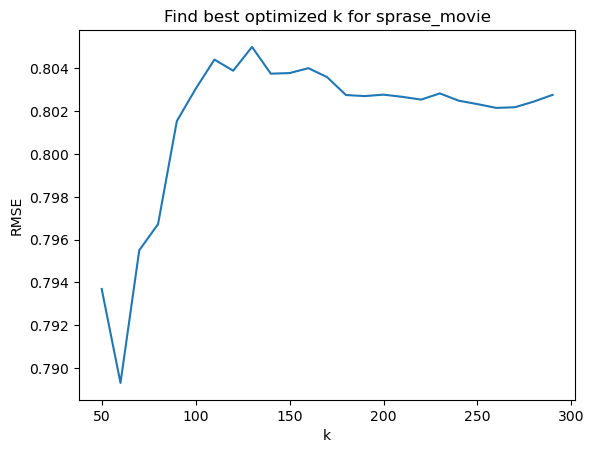

In [37]:
plt.plot(movie_k_find_df)
plt.title('Find best optimized k for sprase_movie')
plt.ylabel('RMSE')
plt.xlabel('k')
plt.show()


In [35]:
user_k_find_df.sort_values('rmse', ascending=True)

,rmse
50,0.887551
60,0.888129
70,0.888895
290,0.891435
280,0.891519
260,0.891528
250,0.891596
270,0.891618
240,0.891684
230,0.891793


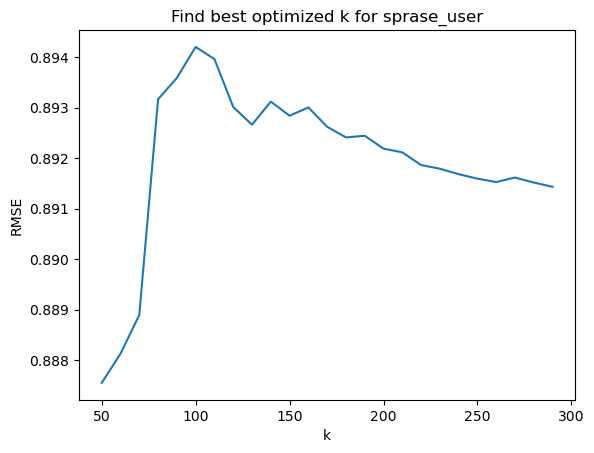

In [39]:
plt.plot(user_k_find_df)
plt.title('Find best optimized k for sprase_user')
plt.ylabel('RMSE')
plt.xlabel('k')
plt.show()
